# Simulations TVA - Budget 2025 : Chapitre socio-fiscal

In [4]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import new_get_inflators_by_year
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [5]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
 'niveau_de_vie',
 'niveau_vie_decile',
 'ocde10',
 'pondmen',
 'nactifs',
 'npers']

In [6]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [7]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [8]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

In [7]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']

In [8]:
difference_menage = pd.DataFrame()
difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage[['depenses_tot','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']] = baseline_menage[['depenses_tot','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']]
for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] > 1)

In [9]:
difference_menage['cinquantieme_niveau_vie'] = weighted_quantiles(difference_menage['niveau_de_vie'], labels = np.arange(1,51), weights = difference_menage['pondmen'], return_quantiles=False)

In [10]:
perc_2 = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] == 1, :]
list_var = perc_2.columns.tolist()
list_var.remove('pondmen')
average_perc_2 = df_weighted_average_grouped(perc_2,'actifs',list_var)
average_perc_2['pondmen'] = perc_2.groupby(by = 'actifs')['pondmen'].sum()
average_perc_2['npers'] = average_perc_2['npers'].round()
average_perc_2['actifs'] = average_perc_2['actifs'].astype('bool')

difference_menage = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] > 1] 
difference_menage = pd.concat([difference_menage,average_perc_2])
difference_menage = difference_menage.reset_index().drop('index', axis = 1) 

### Passage base ménages -> base individuelle

In [11]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)

In [12]:
difference_menage['npers'].sum(), len(difference_indiv)

(28124.0, 28124)

### Les effets d'une hausse de TVA par décile de niveau de vie

In [18]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_indiv['depenses_totales_par_uc'] = difference_indiv['depenses_totales'] / difference_indiv['ocde10']
for taux in liste_taux:
   difference_indiv['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [14]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

In [19]:
difference_by_decile

,depenses_totales_par_uc,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,
1,-119.375231,12722.739418,-64.091691,-17.601781,-36.183720,-1.498034,-0.503757,-0.138349,-0.284402,-0.011774,-0.938282
2,-135.195455,19735.870687,-72.993115,-18.110569,-41.726080,-2.365646,-0.369850,-0.091765,-0.211423,-0.011987,-0.685024
3,-148.725908,23909.334232,-82.166295,-20.537293,-43.816215,-2.206127,-0.343658,-0.085897,-0.183260,-0.009227,-0.622041
4,-170.234543,27638.286547,-92.392451,-24.404806,-50.742000,-2.695369,-0.334292,-0.088301,-0.183593,-0.009752,-0.615937
5,-190.032946,31160.615839,-101.572100,-33.396866,-51.761935,-3.302002,-0.325963,-0.107177,-0.166113,-0.010597,-0.609850
6,-221.248081,34832.914406,-108.671413,-50.730795,-58.381647,-3.464324,-0.311979,-0.145640,-0.167605,-0.009946,-0.635170
7,-216.217472,38862.703620,-116.533033,-35.994900,-60.494409,-3.195098,-0.299858,-0.092621,-0.155662,-0.008222,-0.556362
8,-255.168095,44124.278452,-132.236693,-48.374729,-70.590403,-3.966258,-0.299691,-0.109633,-0.159981,-0.008989,-0.578294
9,-278.315382,52176.480431,-143.205322,-52.778434,-77.186499,-5.145139,-0.274463,-0.101154,-0.147934,-0.009861,-0.533412


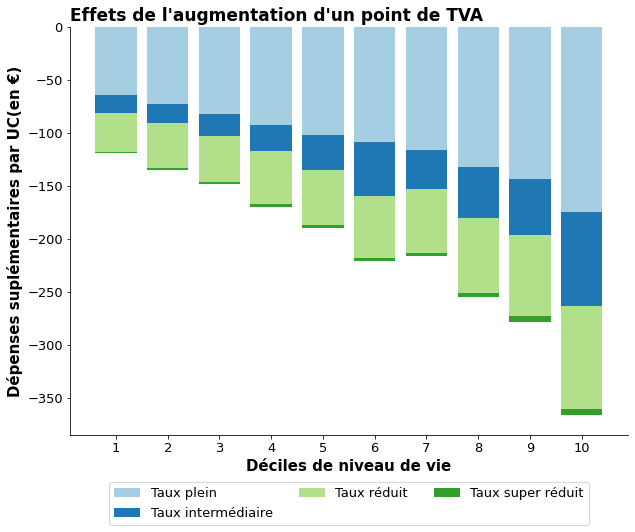

In [20]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires par UC(en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

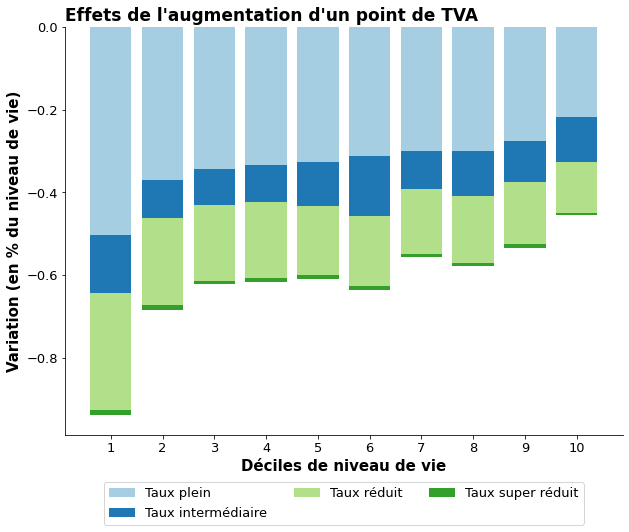

In [21]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

#### Décomposition actifs / inactifs

In [22]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 1], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100



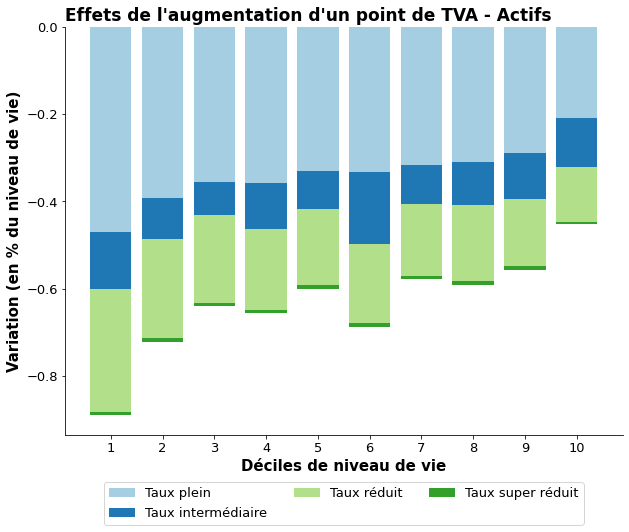

In [23]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf')

In [24]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 0], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                    )
for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

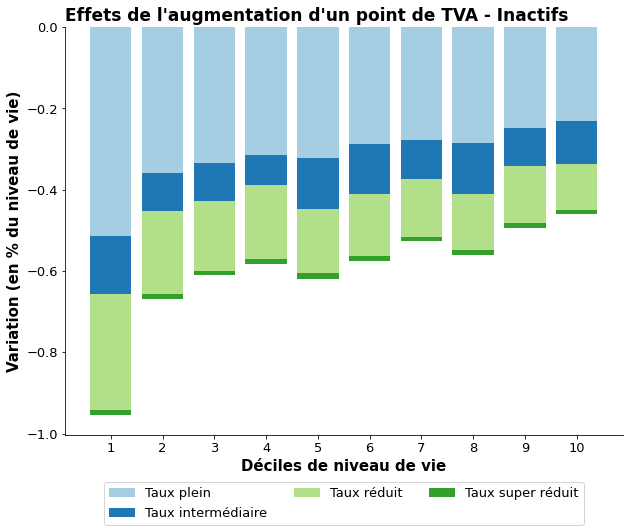

In [25]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs.pdf')

In [27]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import double_stacked_bar_plot

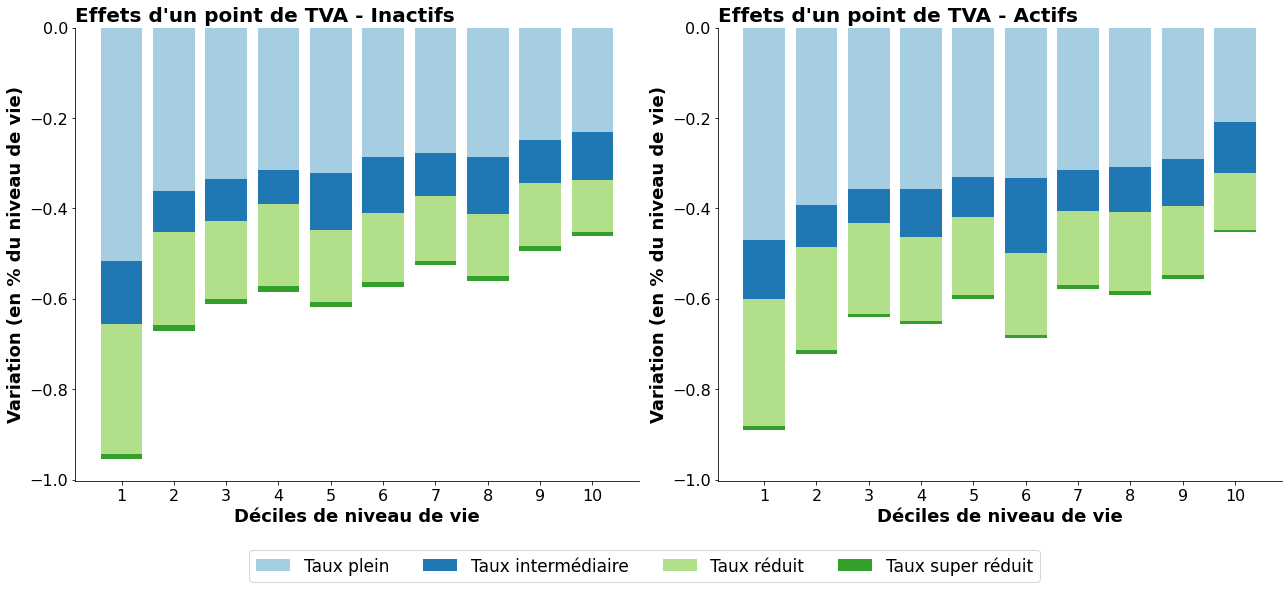

In [28]:
double_stacked_bar_plot(difference_by_decile_not_actifs,
                        difference_by_decile_actifs, 
                        variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                        labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                        title1 = "Effets d'un point de TVA - Inactifs",
                        title2 = "Effets d'un point de TVA - Actifs",
                        xlabel = 'Déciles de niveau de vie' ,
                        ylabel = 'Variation (en % du niveau de vie)',
                        colors = list(sns.color_palette("Paired")),
                        savefig = True,
                        outfile = 'Taux_effort_actifs_not_actifs.pdf')

In [29]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'

In [30]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'

to_graph_all = difference_by_decile[['Taux_effort_total']] 
to_graph_all.to_csv(os.path.join(output_data_path,'to_graph_all.csv'), sep = ',', index = True)

# Actifs en emploi uniquement
to_graph_actifs_only = difference_by_decile_actifs[['Taux_effort_total']]
to_graph_actifs_only.to_csv(os.path.join(output_data_path,'to_graph_actifs_only.csv'), sep = ',', index = True)

# Inactifs sans emploi
to_graph_not_actifs = difference_by_decile_not_actifs[['Taux_effort_total']]
to_graph_not_actifs.to_csv(os.path.join(output_data_path,'to_graph_not_actifs.csv'), sep = ',', index = True)

### Analyse par vingtième de niveau de vie

In [ ]:
difference_indiv['vingtieme_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,21), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['vingtieme_indiv_niveau_vie'] = difference_indiv['vingtieme_indiv_niveau_vie'].astype(int)

In [ ]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_by_vingtieme = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'vingtieme_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_totales','niveau_de_vie','rev_disponible','ocde10'] +
                                                   ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_vingtieme['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_vingtieme['depenses_tva_taux_{}'.format(taux)] / difference_by_vingtieme['rev_disponible'] * 100
difference_by_vingtieme['Taux_effort_total'] = difference_by_vingtieme['depenses_totales'] / difference_by_vingtieme['rev_disponible'] * 100

In [ ]:
difference_by_vingtieme

,depenses_tot,depenses_totales,niveau_de_vie,rev_disponible,ocde10,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
vingtieme_indiv_niveau_vie,,,,,,,,,,,,,,
1,30447.749859,-205.645707,9714.865774,17951.582571,1.737600,-105.458285,-31.230198,-66.707550,-2.249701,-0.587460,-0.173969,-0.371597,-0.012532,-1.145558
2,33554.970420,-229.568854,15727.373460,31543.518472,2.002623,-126.195949,-29.690278,-70.827707,-2.854763,-0.400069,-0.094125,-0.224540,-0.009050,-0.727785
3,37692.613209,-264.654903,18534.013447,36968.648502,1.993161,-144.520686,-33.120223,-82.766804,-4.247041,-0.390928,-0.089590,-0.223884,-0.011488,-0.715890
4,36748.903747,-253.020016,20937.682493,39341.852948,1.876755,-136.174979,-34.055576,-78.704871,-4.084527,-0.346133,-0.086563,-0.200054,-0.010382,-0.643132
5,38835.764824,-262.765215,22896.662390,42159.993242,1.840678,-145.971577,-33.058312,-80.289254,-3.446051,-0.346232,-0.078412,-0.190439,-0.008174,-0.623257
6,41540.282636,-285.751925,24924.124212,45756.181241,1.834260,-153.983350,-43.151025,-84.699318,-3.918326,-0.336530,-0.094306,-0.185110,-0.008563,-0.624510
7,46340.903982,-325.240456,26765.196399,49575.521380,1.852274,-173.481527,-50.470127,-96.297101,-4.991903,-0.349934,-0.101805,-0.194243,-0.010069,-0.656050
8,44348.923956,-303.891393,28511.509437,51325.293325,1.798922,-167.267381,-39.958867,-92.635403,-4.029853,-0.325897,-0.077854,-0.180487,-0.007852,-0.592089
9,47155.404315,-330.774472,30267.822047,54319.179598,1.794109,-173.304981,-60.317138,-92.280993,-4.871363,-0.319049,-0.111042,-0.169887,-0.008968,-0.608946


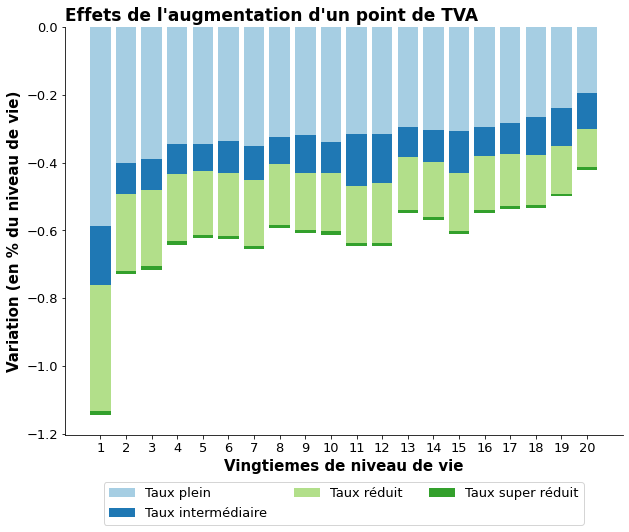

In [ ]:
stacked_bar_plot(difference_by_vingtieme, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Vingtiemes de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = '')

In [ ]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import (new_get_inflators_bdf_to_cn,
                                                                                         new_get_cn_aggregates)

In [ ]:
inflators_2017 = new_get_inflators_bdf_to_cn(2017)

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\TVA_Herve_IPP\new_calage_bdf_cn.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_bdf_postes_cn[poste] = 0


In [ ]:
list(inflators_2017.keys())

['poste_01_1_1',
 'poste_01_1_2',
 'poste_01_1_3',
 'poste_01_1_4',
 'poste_01_1_5',
 'poste_01_1_6',
 'poste_01_1_7',
 'poste_01_1_8',
 'poste_01_1_9',
 'poste_01_2_1',
 'poste_01_2_2',
 'poste_01_2_3',
 'poste_01_2_5',
 'poste_01_2_6',
 'poste_01_2_9',
 'poste_02_1_1',
 'poste_02_1_2',
 'poste_02_1_3',
 'poste_02_1_9',
 'poste_02_3',
 'poste_03_1_1',
 'poste_03_1_2',
 'poste_03_1_3',
 'poste_03_1_4',
 'poste_03_2_1',
 'poste_03_2_2',
 'poste_04_1_1',
 'poste_04_1_2',
 'loyer_impute',
 'poste_04_3_1',
 'poste_04_3_2',
 'poste_04_4_1',
 'poste_04_4_2',
 'poste_04_4_4',
 'poste_04_5_1',
 'poste_04_5_2',
 'poste_04_5_3',
 'poste_04_5_4',
 'poste_04_5_5',
 'poste_05_1',
 'poste_05_2',
 'poste_05_3_1',
 'poste_05_3_2',
 'poste_05_3_3',
 'poste_05_4',
 'poste_05_5_1',
 'poste_05_5_2',
 'poste_05_5_3',
 'poste_05_6_1',
 'poste_05_6_2',
 'poste_06_1',
 'poste_06_2',
 'poste_06_3',
 'poste_06_4',
 'poste_07_1_1',
 'poste_07_1_2',
 'poste_07_1_3',
 'poste_07_2_1',
 'poste_07_2_2',
 'poste_07_2_

In [ ]:
len(list(inflators_2017.keys())) - 2

124

In [ ]:
masses_cn_data_frame = new_get_cn_aggregates(2017)

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
set(list(masses_cn_data_frame.index)).difference(set(list(inflators_2017.keys())))

{'poste_02_4', 'poste_04_4_3'}

In [ ]:
from openfisca_france_indirect_taxation.scripts.build_coicop_bdf import bdf
from openfisca_france_indirect_taxation.scripts.new_build_coicop_bdf import new_bdf

In [ ]:
data_frame = bdf(2017)

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\openfisca_survey_manager\coicop.py:77: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  coicop_nomenclature = pd.merge(coicop_nomenclature, build_coicop_level_nomenclature(next_level), on = on)


In [ ]:
data_frame.loc[data_frame['code_coicop'].isin(['04.5.1.1.1.a','04.5.1.1.1.b','04.5.2.1.1','04.5.2.2.1','04.5.3.1.1', '04.5.4.1.1', '04.5.5.1.1'])]

,label_division,label_groupe,label_classe,label_sous_classe,label_poste,poste_coicop,code_coicop,label,code_bdf
404,NaN,NaN,NaN,NaN,NaN,NaN,04.5.1.1.1.a,Facture électricité + gaz (non dissociables),c04500
405,NaN,NaN,NaN,NaN,NaN,NaN,04.5.1.1.1.b,"Facture d'électricité résidence principale, au...",c04511
406,NaN,NaN,NaN,NaN,NaN,NaN,04.5.2.1.1,"Facture de gaz résidence principale, autre log...",c04521
407,NaN,NaN,NaN,NaN,NaN,NaN,04.5.2.2.1,"Achats de butane, propane résidence principale...",c04522
408,NaN,NaN,NaN,NaN,NaN,NaN,04.5.3.1.1,Combustibles liquides pour la résidence princi...,c04531
409,NaN,NaN,NaN,NaN,NaN,NaN,04.5.4.1.1,Combustible solide résidence principale,c04541
410,NaN,NaN,NaN,NaN,NaN,NaN,04.5.5.1.1,Chauffage urbain (par vapeur),c04551


In [ ]:
new_coicop_data_frame = new_bdf(2017)

In [ ]:
new_coicop_data_frame.loc[data_frame['code_coicop'].isin(['04.5.1.1.1.a','04.5.1.1.1.b','04.5.2.1.1','04.5.2.2.1','04.5.3.1.1', '04.5.4.1.1', '04.5.5.1.1'])]

ValueError: cannot reindex from a duplicate axis

In [ ]:
from openfisca_france_indirect_taxation.build_survey_data import step_5_data_from_matching
data_matched = step_5_data_from_matching.main(2017)

KeyError: "['poste_04_5_1_1_1_a', 'poste_04_5_1_1_1_b', 'poste_04_5_2_1_1', 'poste_04_5_2_2_1', 'poste_04_5_3_1_1', 'poste_04_5_4_1_1', 'poste_04_5_5_1_1'] not in index"

In [6]:
from openfisca_survey_manager.coicop import build_raw_coicop_nomenclature

In [7]:
build_raw_coicop_nomenclature()

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\openfisca_survey_manager\coicop.py:77: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  coicop_nomenclature = pd.merge(coicop_nomenclature, build_coicop_level_nomenclature(next_level), on = on)


,label_division,label_groupe,label_classe,label_sous_classe,label_poste,code_coicop
0,Produits alimentaires et boissons non alcoolisées,Produits alimentaires,Pain et céréales,Pain,Pain,1.1.1.1.1
1,Produits alimentaires et boissons non alcoolisées,Produits alimentaires,Pain et céréales,Pâtisserie fraîche et viennoiserie,Pâtisserie fraîche,1.1.1.2.1
2,Produits alimentaires et boissons non alcoolisées,Produits alimentaires,Pain et céréales,Pâtisserie fraîche et viennoiserie,Viennoiserie,1.1.1.2.2
3,Produits alimentaires et boissons non alcoolisées,Produits alimentaires,Pain et céréales,"Gâteaux, pâtisserie de conservation","Biscottes, triscottes, pains durs",1.1.1.3.1
4,Produits alimentaires et boissons non alcoolisées,Produits alimentaires,Pain et céréales,"Gâteaux, pâtisserie de conservation",Biscuits et gâteaux,1.1.1.3.2
...,...,...,...,...,...,...
300,Autres biens et services,Services financiers,Services financiers n.d.a.,Services financiers,Services financiers,12.6.1.1.1
301,Autres biens et services,Autres services,Autres services,Services funéraires,Services funéraires,12.7.1.1.1
302,Autres biens et services,Autres services,Autres services,Prestations administratives et privées diverses,Formalités administratives,12.7.1.2.1
303,Autres biens et services,Autres services,Autres services,Prestations administratives et privées diverses,Services juridiques,12.7.1.2.2
